# 802.11ad : Controlled experiments in the lab

The objective of these experiments was to find the root cause for the time gap between two instants: (1) having an 802.11ad client within range of an 802.11ad AP; and (2) having the client and AP able to communicate between each other using the 'gluten' app. 

We call this the **'connectivity time gap'** or **CTG**.

### Questions answered here:

* How long are CTGs anyway?
* Does the CTG depend on the duration of 'out-of-range' periods?
* Suspect nr. 1 is 802.11ad sector sweeps. How long do they take? How frequently?
* Do long CTGs correlate with OS errors? If so, which?

### Methodology

To simulate 'out-of-range' conditions, we've used a setup with a metal sheet as shown [here](https://www.dropbox.com/s/ah5cmdpoauqs1b4/experiment-ad-connectivity.key?dl=0).

### Imports and definitions

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import warnings
import hashlib
import matplotlib
import matplotlib.pyplot as plt
import timeit
import numpy as np

warnings.filterwarnings('ignore')
pd.set_option('display.float_format', '{:.5f}'.format)

## How long are CTGs?

### Group experimental data into 'connected' and 'unconnected' blocks

In [3]:
logs_dir = '/Users/adamiaonr/Downloads/ad-reconnect-experiments/logs'

tghpt_data = pd.read_csv(os.path.join(logs_dir, ('consumer.csv')))
los_data = pd.read_csv(os.path.join(logs_dir, ('los.csv')))
syslog_data = pd.read_csv(os.path.join(logs_dir, ('logread.csv')))

# mark row blocks of contiguous time
#tghpt_data['time-block'] = ((tghpt_data['timestamp'] - tghpt_data['timestamp'].shift(1) > 5)).astype(int).cumsum()

# mark contiguous row blocks with similar time blocks, ad connectivity and speed profiles
tghpt_data['ad-on'] = 0
tghpt_data.loc[tghpt_data['throughput'] > 0.0, 'ad-on'] = 1
tghpt_data['ad-block'] = ((tghpt_data['ad-on'].shift(1) != tghpt_data['ad-on']) | (tghpt_data['timestamp'] - tghpt_data['timestamp'].shift(1) > 3)).astype(int).cumsum()

syslog_data['timestamp'] = syslog_data['timestamp'].round().astype(int)
tghpt_data = pd.merge(tghpt_data, syslog_data, on = ['timestamp'], how = 'left')

tghpt_blocks = tghpt_data.groupby(['ad-block']).agg({'timestamp' : [lambda t : t.max() - t.min(), 'min'], 'throughput' : 'mean', 'proto' : lambda x : list(set(x[~np.isnan(x)])), 'wmi' : lambda x : list(set(x[~np.isnan(x)]))}).reset_index(drop = False)
tghpt_blocks.columns = tghpt_blocks.columns.map('.'.join)
tghpt_blocks = tghpt_blocks.reset_index(drop = False)
tghpt_blocks.rename(index = str, columns = {
    'timestamp.<lambda_0>' : 'duration', 
    'timestamp.min' : 'timestamp',
    'ad-block.' : 'ad-block',
    'proto.<lambda>' : 'proto',
    'wmi.<lambda>' : 'wmi'}, inplace = True)

tghpt_blocks = tghpt_blocks.tail(len(los_data)).reset_index(drop = True)
tghpt_blocks[['timestamp-los', 'status-los']] = los_data[['timestamp', 'los-stats']]
tghpt_blocks['gap'] = tghpt_blocks['timestamp'] - tghpt_blocks['timestamp-los']

# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(tghpt_blocks[['timestamp', 'status-los', 'duration', 'gap', 'proto', 'wmi']])


## Plot CTG

* CTG can vary between 2 to 40 seconds
* No clear correlation between CTG values and 'out-of-range' period


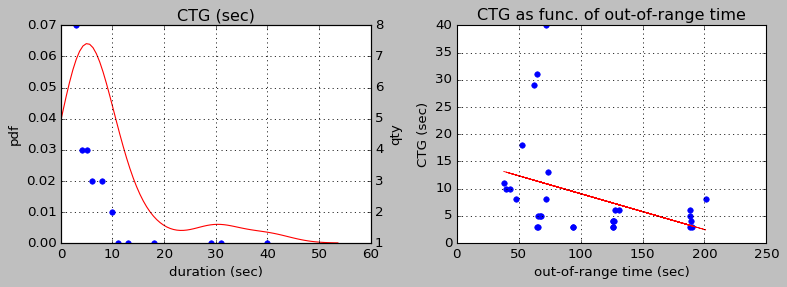

In [25]:
import seaborn as sb
from sklearn.linear_model import LinearRegression

def plot_cdf(ax, data, metric, plot_configs):

    ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)

    data = data.sort_values(by = [metric])
    if 'counts' not in data:
        cdf = data.groupby([metric]).size().reset_index(name = 'counts')
    else:
        cdf = data

    cdf['counts'] = np.array(cdf['counts'].cumsum(), dtype = float)
    cdf['counts'] = cdf['counts'] / cdf['counts'].values[-1]

    ax.plot(cdf[metric], cdf['counts'], 
        alpha = .75,
        linewidth = 1.00, 
        color = 'blue', 
        linestyle = '-')

    ax.set_ylabel("CDF")
    ax.set_yticks(np.arange(0.0, 1.1, 0.25))
    
    ax.tick_params(axis = 'both', which = 'major')
    ax.tick_params(axis = 'both', which = 'minor')

def plot_pdf(ax, data, var, plot_configs):

    ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
    ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)
    
    # pdf on main axis
    sb.kdeplot(data.sort_values(by = [var], ascending = True)[var], ax = ax, color = 'red', label = '')
    ax.set_ylabel('pdf')
    # absolute count on secondary axis
    ax2 = ax.twinx()
    counts = data.groupby([var]).size().reset_index(drop = False, name = 'count')
    counts = counts.sort_values(by = [var])
    ax2.plot(counts[var], counts['count'], color = 'blue', linewidth = 0.0, marker = '.', markersize = 10.0)
    ax2.set_ylabel('qty')
            
def plot_distribution(ax, data, var, plot_configs = {}):
    
    ax.set_title(plot_configs['title'])
    
    if plot_configs['plot-type'] == 'cdf':
        plot_cdf(ax, data, var, plot_configs)
    elif plot_configs['plot-type'] == 'pdf':
        plot_pdf(ax, data, var, plot_configs)

    # x-axis
    ax.set_xlabel(plot_configs['x-label'])
    ax.set_xlim(plot_configs['x-lim'])
    ax.set_xscale(plot_configs['x-type'])

variables = {
    'a' : {
        'v' : 'gap',
        'x-label' : 'duration (sec)',
        'x-lim' : [0.0, 60.0],
        'x-type' : 'linear',
        'plot-type' : 'pdf',
        'title' : 'CTG (sec)',
    },
}

plt.style.use('classic')
fig = plt.figure(figsize = ((10.0), (3.75)))

plot_configs = {'x-label' : '', 'y-label' : '# of samples', 'title' : '', 'color' : 'blue'}
for i, v in enumerate(variables.keys()):
    plot_configs['x-label'] = variables[v]['x-label']
    plot_configs['x-lim'] = variables[v]['x-lim']
    plot_configs['x-type'] = variables[v]['x-type']
    plot_configs['title'] = variables[v]['title']
    plot_configs['plot-type'] = variables[v]['plot-type']
    ax = fig.add_subplot(1, 2, i + 1)
    plot_distribution(ax, tghpt_blocks[tghpt_blocks['status-los'] > 0], var = variables[v]['v'], plot_configs = plot_configs)

# scatter plot gap vs. duration of disconnection
ax = fig.add_subplot(1, 2, 2)
ax.set_title('CTG as func. of out-of-range time')
ax.xaxis.grid(True, ls = 'dotted', lw = 0.75)
ax.yaxis.grid(True, ls = 'dotted', lw = 0.75)

ax.plot(tghpt_blocks[tghpt_blocks['status-los'] == 0]['duration'], tghpt_blocks[tghpt_blocks['status-los'] == 1]['gap'], color = 'blue', linewidth = 0.0, marker = '.', markersize = 10.0)

x = tghpt_blocks[tghpt_blocks['status-los'] == 0]['duration'].values.reshape(-1, 1)
y = tghpt_blocks[tghpt_blocks['status-los'] == 1]['gap'].values.reshape(-1, 1)

linear_regressor = LinearRegression()
linear_regressor.fit(x, y)
yy = linear_regressor.predict(x)
ax.plot(x, yy, color = 'red', linewidth = 0.75)

ax.set_xlabel('out-of-range time (sec)')
ax.set_ylabel('CTG (sec)')

fig.tight_layout()
plt.show()

## Duration of sector sweeps

### Functions & definitions

In [10]:
sweep_frame_types = {360 : 'ssw', 361 : 'ssw-feedback', 362 : 'ssw-feedback-ack'}
sweep_data = pd.read_csv(os.path.join(logs_dir, ('monitor.ad.sweep.csv')))

In [37]:
def convert_snr(data):
    # wlan.sswf.snr_report : encoded as 8-bit twos complement value of 4×(SNR-19), where SNR is measured in dB    
    msbs = ((data[data['wlan.fc.type_subtype'] > 360]['wlan.sswf.snr_report'].astype(int) & 0x0080)).values
    msbs = np.array([ float((int(msb) >> 7) * -128.0) for msb in msbs ])
    lsbs = data[data['wlan.fc.type_subtype'] > 360]['wlan.sswf.snr_report'] + msbs
        
    data['wlan.sswf.snr_report.converted'] = 0.0
    data.loc[data['wlan.fc.type_subtype'] > 360, 'wlan.sswf.snr_report.converted'] = ((lsbs + msbs) / 4.0) + 19.0

def chosen_sectors(data, mac_addrs = {'50:c7:bf:97:8a:a6' : 'ap', '50:c7:bf:3c:53:1c' : 'client_1', '70:4f:57:72:b2:58' : 'client_2'}):
    
    for addr in mac_addrs:
        
        if addr not in list(sweep_data['wlan.ta'].unique()):
            continue
        
        col_name = ('wlan.sswf.sector_select.%s' % (mac_addrs[addr]))
        sweep_data[col_name] = -1
        sweep_data.loc[(sweep_data['wlan.fc.type_subtype'].isin([361, 362])) & (sweep_data['wlan.ra'] == addr), col_name] = sweep_data[(sweep_data['wlan.fc.type_subtype'].isin([361, 362])) & (sweep_data['wlan.ra'] == addr)]['wlan.sswf.sector_select']

# identify ssw blocks
sweep_data['timestamp'] = sweep_data['frame.time_epoch'].astype(int)
sweep_data['time-block'] = ((sweep_data['timestamp'] - sweep_data['timestamp'].shift(1) > 5)).astype(int).cumsum()
# convert ssw snr
convert_snr(sweep_data)
# sectors chosen by client and ap
chosen_sectors(sweep_data)

sweep_data['ssw-type'] = 0
sweep_data.loc[sweep_data['wlan.fc.type_subtype'] > 361, 'ssw-type'] = 1
sweep_data['ssw-block'] = ((sweep_data['ssw-type'].shift(1) != sweep_data['ssw-type']) & (sweep_data['ssw-type'] == 0)).astype(int).cumsum()

#print(list(sweep_data.columns))

In [48]:
sweep_blocks = sweep_data.groupby(['ssw-block']).agg(
    {'frame.time_epoch' : [lambda t : t.max() - t.min(), 'size', 'min'],
     'wlan.sswf.sector_select.ap' : lambda x : sorted(list(set(x)))[-1],
     'wlan.sswf.sector_select.client_1' : lambda x : sorted(list(set(x)))[-1],
    })

sweep_blocks.columns = sweep_blocks.columns.map('.'.join)
sweep_blocks = sweep_blocks.reset_index(drop = False)
sweep_blocks.rename(index = str, columns = {
    'frame.time_epoch.<lambda_0>' : 'duration', 
    'frame.time_epoch.size' : 'samples', 
    'frame.time_epoch.min' : 'timestamp',
    'wlan.sswf.sector_select.ap.<lambda>' : 'wlan.sswf.sector_select.ap',
    'wlan.sswf.sector_select.client_1.<lambda>' : 'wlan.sswf.sector_select.client_1'}, inplace = True)

sweep_blocks['duration'] *= 1000.0


In [ ]:
# remove rows w/ no ap nor client selected blocks
sweep_blocks_fltrd = sweep_blocks[(sweep_blocks['wlan.sswf.sector_select.ap'] > -1.0) & (sweep_blocks['wlan.sswf.sector_select.client_1'] > -1.0)]
# remove 'duration' and 'samples' outliers based on z-score
# sweep_blocks_fltrd['duration-z-score'] = (sweep_blocks_fltrd['duration'] - sweep_blocks_fltrd['duration'].mean()) / sweep_blocks_fltrd['duration'].std()
# sweep_blocks_fltrd['samples-z-score'] = (sweep_blocks_fltrd['samples'] - sweep_blocks_fltrd['samples'].mean()) / sweep_blocks_fltrd['samples'].std()
# sweep_blocks_fltrd = sweep_blocks_fltrd[(sweep_blocks_fltrd['duration-z-score'] < 3.0) & (sweep_blocks_fltrd['samples-z-score'] < 3.0)]
sweep_blocks_fltrd['time'] = sweep_blocks_fltrd['timestamp'].astype(int)
# round duration to .0
sweep_blocks_fltrd['duration'] = sweep_blocks_fltrd['duration'].round(0)

# sweep_block_stats = sweep_blocks_fltrd.groupby(['duration']).size().reset_index(drop = False, name = 'count')
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#    print(sweep_block_stats.sort_values(by = ['duration'], ascending = False))

### Plots of duration of sector sweeps

Sector sweeps aren't the culprit apparently:

* Sector sweeps are very short : < 200 msec in 75% of the cases
* Regarding longer sector sweeps, there doesn't seem to be a correlation between CTG and the duration of sector sweeps (see prints below). In fact, I suspect the long duration sector sweeps are due to interpretation erros, e.g. due to missing feedback frames in the captures. 
* The nr. of sector sweeps per second is low : up to a maximum of 3 per second. As such, large CTGs wouldn't result from consecutive sector sweeps.

In [57]:
print(sweep_blocks_fltrd[sweep_blocks_fltrd['duration'] > 1000.0][['timestamp', 'duration']].sort_values(by = ['timestamp'], ascending = True))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(tghpt_blocks[tghpt_blocks['gap'] > 10.0][['timestamp', 'gap']])

           timestamp     duration
75  1568122402.25526  38751.00000
132 1568122443.76829   2870.00000
178 1568122457.20460  67051.00000
231 1568122547.12948 130622.00000
293 1568122699.34709 191088.00000
323 1568122903.18967  36806.00000
406 1568122991.32488  67045.00000
452 1568123072.47391 127924.00000
495 1568123222.09534 189964.00000
576 1568123481.07532  10448.00000
656 1568123588.90914 127594.00000
747 1568123745.61791 197495.00000
824 1568124018.99794   4909.00000
902 1568124119.83127 127922.00000
958 1568124261.01411 190822.00000
     timestamp  gap
1   1568120756   11
21  1568121934   31
31  1568122534   13
37  1568122976   40
45  1568123497   29
53  1568124024   18


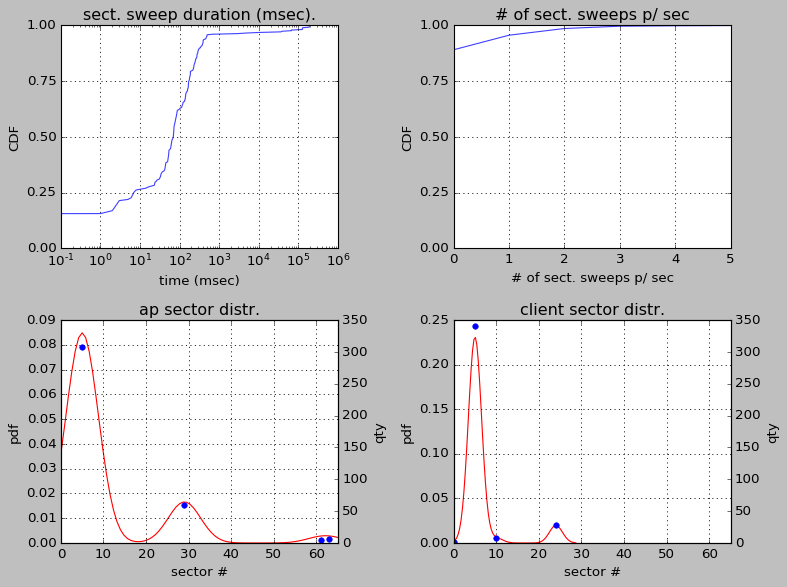

In [52]:
variables = {
    'duration' : {
        'v' : 'duration',
        'x-label' : 'time (msec)',
        'x-lim' : [0.1, 1000000.0],
        'x-type' : 'log',
        'plot-type' : 'cdf',
        'title' : 'sect. sweep duration (msec).',
    },
    'freq' : {
        'v' : 'freq',
        'x-label' : '# of sect. sweeps p/ sec',
        'x-lim' : [0, 5],
        'x-type' : 'linear',
        'plot-type' : 'cdf',
        'title' : '# of sect. sweeps p/ sec',
    },
    'wlan.sswf.sector_select.ap' : {
        'v' : 'wlan.sswf.sector_select.ap',
        'x-label' : 'sector #',
        'x-lim' : [0.0, 65.0],
        'x-type' : 'linear',
        'plot-type' : 'pdf',
        'title' : 'ap sector distr.',
    },
    'wlan.sswf.sector_select.client_1' : {
        'v' : 'wlan.sswf.sector_select.client_1',
        'x-label' : 'sector #',
        'x-lim' : [0.0, 65.0],
        'x-type' : 'linear',
        'plot-type' : 'pdf',
        'title' : 'client sector distr.',
    }
}

plt.style.use('classic')
fig = plt.figure(figsize = ((10.0), (7.5)))

plot_configs = {'x-label' : '', 'y-label' : '# of samples', 'title' : '', 'color' : 'blue'}
for i, v in enumerate(variables.keys()):
    plot_configs['x-label'] = variables[v]['x-label']
    plot_configs['x-lim'] = variables[v]['x-lim']
    plot_configs['x-type'] = variables[v]['x-type']
    plot_configs['plot-type'] = variables[v]['plot-type']
        
    plot_configs['title'] = variables[v]['title']
    ax = fig.add_subplot(2, 2, i + 1)
    
    if v == 'freq':
        # we consider all second precision timestamps 
        # for each 1 sec period, we calculate the nr. of sector sweeps
        ssw_freq = pd.DataFrame()
        ssw_freq['time'] = np.arange(sweep_blocks_fltrd['time'].min(), sweep_blocks_fltrd['timestamp'].max() + 1)
        ssw_freq = pd.merge(ssw_freq, sweep_blocks_fltrd.groupby(['time']).size().reset_index(name = 'freq', drop = False), on = ['time'], how = 'left')
        ssw_freq = ssw_freq.fillna(0)
        plot_distribution(ax, ssw_freq, var = variables[v]['v'], plot_configs = plot_configs)
    else:
        plot_distribution(ax, sweep_blocks_fltrd, var = variables[v]['v'], plot_configs = plot_configs)

fig.tight_layout()
plt.show()

## OS event analysis

OS events are taken from openWRT's equivalent to `syslog`, accessible via the `logread` command.

Every time we have a short CTG (`gap` column), the `proto` and `wmi` columns read { [1], [2, 3] }.

When we have a long CTG, the `proto` and `wmi` columns typically read { [0, 1], [2, 3, 4] }. **It seems `proto` 1 and `wmi` 4 events are critical here.**

### What do `proto` and `wmi` mean?

By analysing external sources and the `wil6210` driver, here's what we know:

#### `proto` events

`proto` events refer to disconnect reasons, [as defined by 802.11 std](https://community.cisco.com/t5/wireless-mobility-documents/802-11-association-status-802-11-deauth-reason-codes/ta-p/3148055). This doesn't tell us much, since reasons 0 and 1 refer to `reserved` and `unspecified reason`, respectively.

#### `wmi` events

`wmi` events refer to disconnect reasons, as defined by the `wil6210` driver, as shown below. 

As such, we can conclude that long CTGs happen when the 802.11ad deliberately orders the client to dissassociate or when the association fails.

| Code        | Reason                 |
| :---        | :---                   |
| 1           | NO_NETWORK_AVAIL       |
| 2           | LOST_LINK              |
| 3           | DISCONNECT_CMD         |
| 4           | BSS_DISCONNECTED       |
| 5           | AUTH_FAILED            |
| 6           | ASSOC_FAILED           |






In [25]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(tghpt_blocks[['timestamp', 'status-los', 'duration', 'gap', 'proto', 'wmi']])

     timestamp  status-los  duration  gap       proto              wmi
0   1568120717           0        38    4       [1.0]       [2.0, 6.0]
1   1568120756           1        29   11          []               []
2   1568120786           0        48    4  [0.0, 1.0]       [2.0, 4.0]
3   1568120835           1        35    8          []               []
4   1568120871           0        67    3       [1.0]            [2.0]
5   1568120939           1        28    5          []               []
6   1568120968           0        94    3       [1.0]            [2.0]
7   1568121063           1        33    3          []               []
8   1568121097           0       126    4       [1.0]            [2.0]
9   1568121224           1        29    4          []               []
10  1568121254           0        40    3       [1.0]       [2.0, 6.0]
11  1568121295           1        19   10          []               []
12  1568121315           0        66    3       [1.0]       [2.0, 3.0]
13  15